In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Loading Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from itertools import cycle                   
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/fake_job_postings.csv', engine='python', encoding='utf-8')

data = data.drop(columns = ['job_id', 'department', 'salary_range', 'location', 'benefits', 
                            'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 
                            'required_experience', 'required_education', 'industry', 'function'])

data['description'] = data['description'].astype(str) 
data.head()

,title,company_profile,description,requirements,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0


# 3. Initial Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            17880 non-null  object
 1   company_profile  14572 non-null  object
 2   description      17880 non-null  object
 3   requirements     15185 non-null  object
 4   fraudulent       17880 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 698.6+ KB


[Text(0, 0, '17014'), Text(0, 0, '866')]

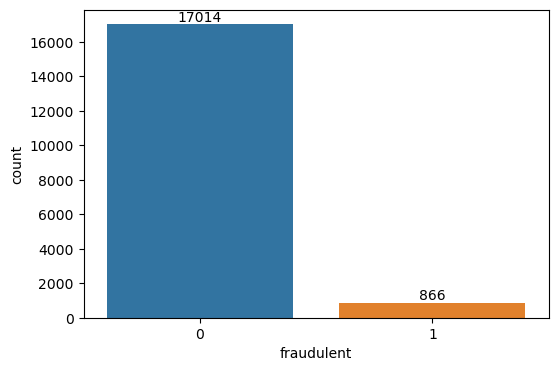

In [5]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'fraudulent')
ax.bar_label(ax.containers[0])

# 4. Preprocessing Text

### 4.3. Merging Columns

In [6]:
# data['combined_text'] = data['Title'] + ' ' + data['Body'] + ' ' + data['Tags']
# data['combined_text'] = data['Title'] + ' ' + data['Body']
data['combined_text'] = data['Body']
data.head()

,Title,Body,Tags,Y,label,combined_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2,<p>I'm already familiar with repeating tasks e...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0,<p>I'd like to understand why Java 8 Optionals...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0,<p>I am attempting to overlay a title over an ...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0,"<p>The question is very simple, but I just cou..."
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0,<p>I'm using custom floatingactionmenu. I need...


### 4.4. Cleaning combined_text Column

In [6]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def clean_text(text):
    text = text.lower()
    text = re.sub(CLEANR, '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub("#+"," ", text)
    text = re.sub("@[\w]*"," ", text)
    text = re.sub("[^a-z\s]"," ", text)
    text = re.sub("@[A-Za-z0-9_]+"," ", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [7]:
data['clean_text'] = data['description'] \
                    .progress_apply(clean_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data.head()

  0%|          | 0/17880 [00:00<?, ?it/s]

  0%|          | 0/17880 [00:00<?, ?it/s]

,title,company_profile,description,requirements,fraudulent,clean_text
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,food fast growing james beard award winning on...
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,organised focused vibrant awesome passion cust...
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,client located houston actively seeking experi...
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,company esri environmental systems instituteou...
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,job title itemization review managerlocation f...


In [8]:
data['clean_text'].values

array(['food fast growing james beard award winning online food community crowd sourced curated recipe hub interviewing time unpaid interns team editors executives developers york city headquarters reproducing repackaging existing food content partner sites huffington post yahoo buzzfeed content management systemsresearching blogs websites provisions food affiliate programassisting day day affiliate program support screening affiliates assisting affiliate inquiriessupporting events neededhelping office administrative filing mailing preparing meetingsworking developers document bugs improvements sitesupporting marketing executive staff',
       'organised focused vibrant awesome passion customer service slick typing skills account management administration cooler polar bear jetski hear cloud video production service opperating glodal level yeah pretty cool delivering class product excellent customer service rapidly expanding business talented project manager manage successful delivery v

In [179]:
# np.savetxt(r'clean_text.csv', data['clean_text'].values, fmt='%s')

### 4.5. Reduce the sentence to be processed according to the desired number of words

<Axes: xlabel='text_len'>

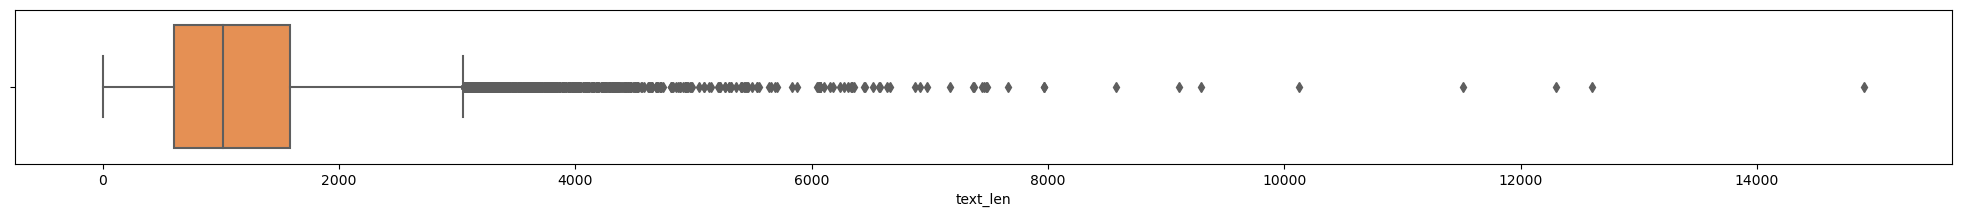

In [12]:
text_len = []

for idx, teks in enumerate(data['description']):
    text_len.append(len(teks))
data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

In [13]:
print(data['text_len'].quantile(0.01))
print(data['text_len'].quantile(0.75))

103.0
1586.0


103.0
1586.0


<Axes: xlabel='text_len'>

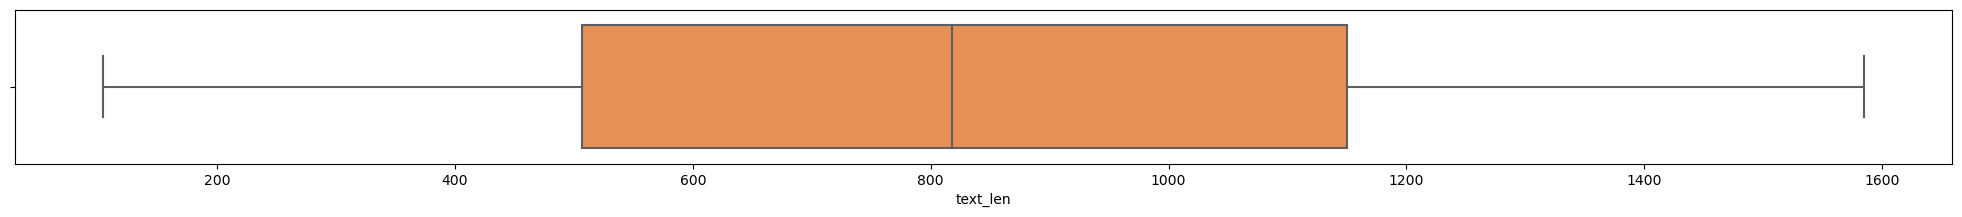

In [14]:
Q1 = data['text_len'].quantile(0.01)
Q3 = data['text_len'].quantile(0.75)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

### 4.6. Visualize # of label after preprocessing

[Text(0, 0, '12576'), Text(0, 0, '649')]

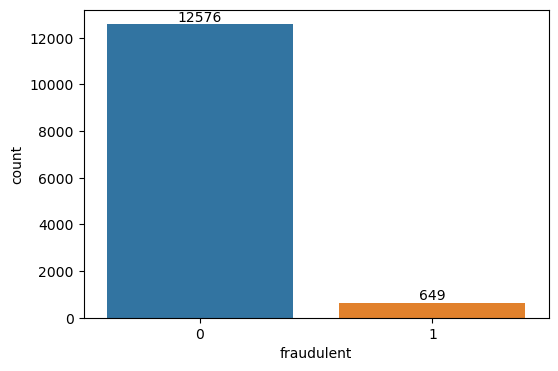

In [15]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'fraudulent')
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting data into Training, Testing, and Validating data

In [16]:
X = data['description']
Y = data['fraudulent']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(9283,)
(2619,)
(1323,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [17]:
vocab_size = 10000
embedding_dim = 128
max_length = 1600
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [97]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

50521


In [18]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

training_label = to_categorical(training_label)
testing_label = to_categorical(testing_label)
validating_label = to_categorical(validating_label)


50521


### 5.4. Build Deep Learning Models

In [31]:
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.) ### 0.9
# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.) ### 0.8004
# initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.) ### 0.8842
# initializer = tf.keras.initializers.Zeros() ### 0.3400
# initializer = tf.keras.initializers.Ones()
# initializer = tf.keras.initializers.GlorotNormal() ### 0.8963
# initializer = tf.keras.initializers.GlorotUniform() ### 0.8916
initializer = tf.keras.initializers.HeNormal() ### 0.9082
# initializer = tf.keras.initializers.HeUniform()
# initializer = tf.keras.initializers.Identity()
# initializer = tf.keras.initializers.Orthogonal()
# initializer = tf.keras.initializers.Constant(3.)
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(Dropout(0.4))
    model.add(ReLU())
    model.add(MaxPooling1D())

    # model.add(Conv1D(512, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(MaxPooling1D())
    # model.add(Dropout(0.4))
    # model.add(BatchNormalization())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    # model.add(Dropout(0.4))

    model.add(Conv1D(32, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    # model.add(Dropout(0.4))

    # model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(128, activation='swish'))
    # model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))
    return model
    

# model = CNN_Model()
model = LSTM_Model()
# model = GRU_Model()



model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.01)
opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1600, 128)         1280000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 1600, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                

### 5.5. Training the Model

In [32]:
num_epoch = 10
batch_size = 32

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/10
30/30 [==============================] - 17s 453ms/step - loss: 0.6203 - accuracy: 0.6183 - val_loss: 0.4723 - val_accuracy: 0.7719
Epoch 2/10
30/30 [==============================] - 11s 376ms/step - loss: 0.2132 - accuracy: 0.9097 - val_loss: 0.3470 - val_accuracy: 0.8553
Epoch 3/10
30/30 [==============================] - 12s 398ms/step - loss: 0.0604 - accuracy: 0.9828 - val_loss: 0.4165 - val_accuracy: 0.8553
Epoch 4/10
30/30 [==============================] - 12s 402ms/step - loss: 0.0360 - accuracy: 0.9903 - val_loss: 0.4317 - val_accuracy: 0.8509
Epoch 5/10
30/30 [==============================] - 12s 417ms/step - loss: 0.0166 - accuracy: 0.9968 - val_loss: 0.6385 - val_accuracy: 0.8640
Epoch 6/10
30/30 [==============================] - 13s 426ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.5439 - val_accuracy: 0.8465
Epoch 7/10
30/30 [==============================] - 12s 402ms/step - loss: 0.0190 - accuracy: 0.9978 - val_loss: 0.5883 - val_accuracy: 0.8684

# 6. Evaluating Performance

### 6.21. Plotting Accuracy and Loss of the Model

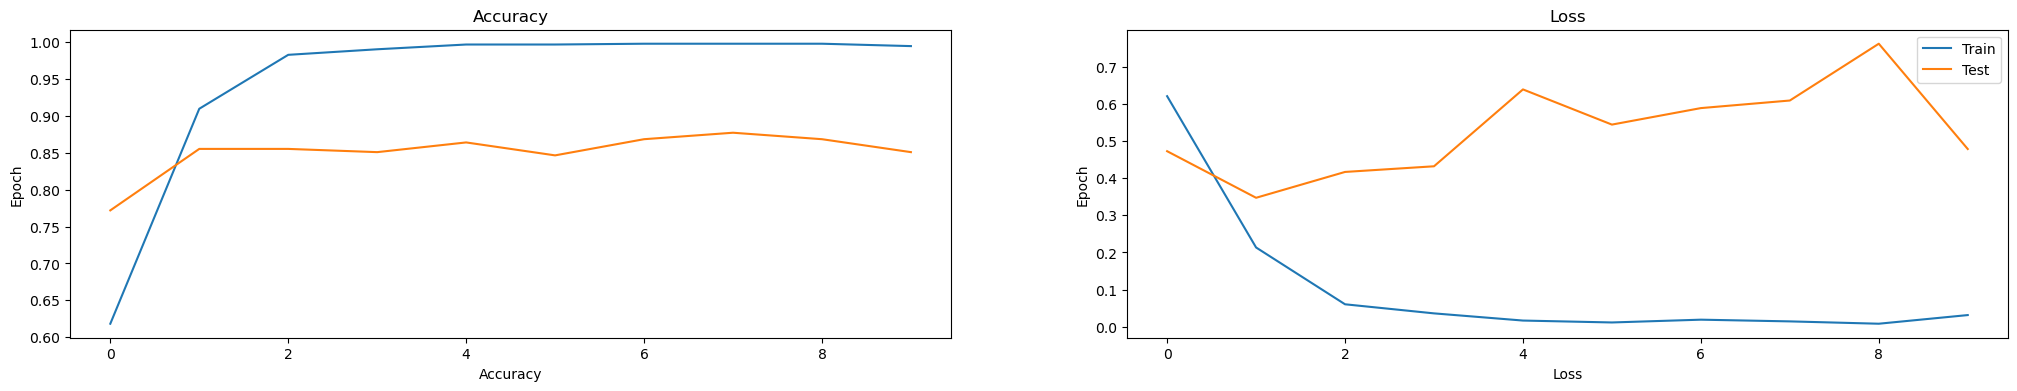

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

### 6.2. Confusion Matrix

5/5 [==============================] - 2s 172ms/step


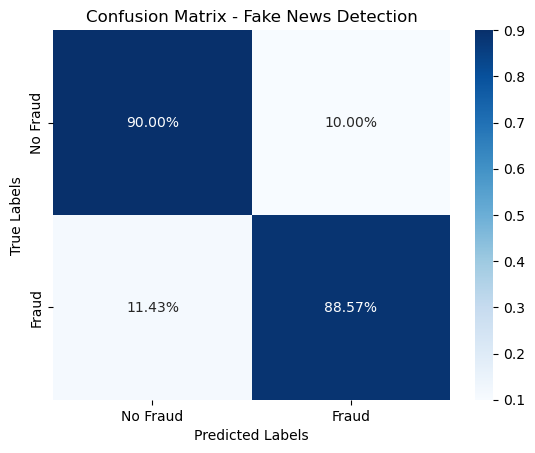

In [34]:
labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [37]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(validating_padded))

print(classification_report(validating_label.argmax(axis=1),y_pred.argmax(axis=1)))

5/5 [==============================] - 1s 176ms/step
              precision    recall  f1-score   support

           0       0.89      0.90      0.89        70
           1       0.90      0.89      0.89        70

    accuracy                           0.89       140
   macro avg       0.89      0.89      0.89       140
weighted avg       0.89      0.89      0.89       140



### 6.3. ROC Curve 

5/5 [==============================] - 1s 159ms/step


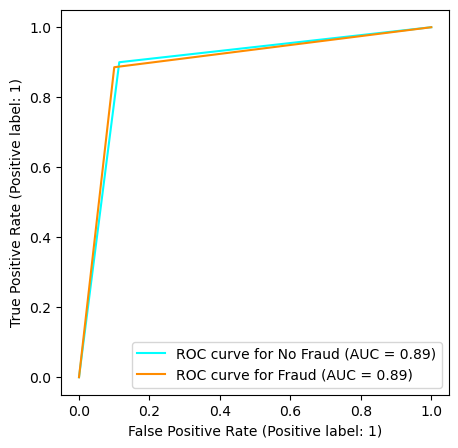

In [38]:
y_pred = np.rint(model.predict(validating_padded))
n_classes = 2

fig, ax = plt.subplots(figsize=(5, 5))
target_names = ['No Fraud', 'Fraud']

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        validating_label[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )